<a href="https://colab.research.google.com/github/AugustvonMackensen/AI_colab/blob/main/gan_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

목표 : 튜토리얼 입력 매개 변수 설명하고 공격중인 모델을 정의 후 공격 코딩하고 일부 테스트 실행

epsilons : 실행 사용될 엡실론 리스트.
엡실론 0은 원래 테스트셋의 모델 성능을 나타내면으로 목록에 유지하는 것이 중요
직관적으로 엡실론이 클수록 작은 변화가 더 눈에 띄지만 모델 정확도를 저하 시키는 측면에서 더 효과가 있음. 데이터 범위는 0-1이기 때문에 엡실론 값은 1 초과하지 못함

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '/data/lenet_mnist_model.pth'
use_cuda = True

모델 및 데이터 로더 정의 후 모델 초기화하고 가중치 읽어오기

Fast Gradient Sign Method

In [3]:
# LeNet 모델 정의
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d() # 전체 채널을 무작위로 0으로 만듬(과적합방지)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 차원 감소 목적(maxpooling), 가장 강한 자극 전달
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# 데이터셋 및 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
          transforms.ToTensor(),
          ])),
      batch_size=1, shuffle=True)

# 어떤 디바이스 사용할 것인가 정의
print('CUDA Available : ', torch.cuda.is_available())
device = torch.device('cuda' if (use_cuda and torch.cuda.is_available()) else 'cpu')

# Initailize the model
model = Net().to(device)

# 미리 학습된 모델 읽기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델 평가 모드로 설정, 드롯아웃 레이어 위해 사용
model.eval()

CUDA Available :  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

FGSM 함수 :
fgsm_attack 함수는 입력 파라미터로 3가지를 가집니다. 첫 번째는 원본 이미지 (  x  ), 두 번째는 엡실론 으로 픽셀 단위의 작은 변화를 주는 값입니다 (  ϵ  ). 마지막은 data_grad 로 입력 영상 (  ∇xJ(θ,x,y)  ) 에 대한 변화도 손실 값입니다. 아래 식에 따른 작은 변화가 적용된 이미지를 생성합니다.

perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))

마지막으로 데이터의 원래 범위를 유지하기 위해, 작은 변화가 적용된 이미지가  [0,1]  범위로 잘립니다.

In [4]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
  # data_grad 요소별 부호 값 얻어오기
  sign_data_grad = data_grad.sign()

  # 입력 이미지 각 픽셀에 sign_data_grad 적용해 작은 변화가 적용된 이미지 생성
  perturbed_image = image + epsilon * sign_data_grad

  # 자르기 : 값 범위를 [0,1]로 유지
  perturbed_image = torch.clamp(perturbed_image, 0, 1)

  # 작은 변화가 적용된 이미지 리턴
  return perturbed_image

테스팅 함수 : 본 튜토리얼의 핵심 결과는 테스트 함수에서 오게 됩니다. 이 테스트 기능을 호출할 때마다 MNIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 보고합니다. 그러나 이 함수에는 엡실론 입력도 필요합니다. 이는 테스트 함수가  ϵ  크기에 따라 공격자의 공격을 받는 모델의 정확도를 보고하기 때문입니다. 더 구체적으로 보면 테스트 셋의 각각의 샘플에서 테스트 함수는 입력 데이터에 대한 손실 변화도(  data_grad  )를 계산하고, FGSM 공격 ( perturbed_data ) 을 받은 작은 변화가 적용된 이미지를 만들고 나서 작은 변화가 적용된 이미지가 적대적인지 확인을 합니다. 추가로 모델의 정확도를 테스트하기 위해서 테스트 함수는 나중에 시각화하여 볼 수 있도록 성공적으로 얻은 적대적 이미지를 저장하고 반환합니다.

In [5]:
def test(model, device, test_loader, epsilon):
  # 정확도 카운터
  correct = 0
  adv_examples = []

  # 테스트상 모든 예제에 대해 루프 돌기
  for data, target in test_loader:

    # 디바이스에 데이터와 라벨값 넘기기
    data, target = data.to(device), target.to(device)

    # 텐서 속성 중 requires_grad 설정 -> 공격에서 중요한 부분
    data.requires_grad = True

    # 데이터를 모델에 통과시키기
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # 로그 확률 최댓값 가지는 인덱스 얻기

    # 초기 예측이 틀리면, 공격하지 않고 계속 진행
    if init_pred.item() != target.item():
      continue

    # 손실 계산
    loss = F.nll_loss(output, target)

    # 모델 변화도를 전부 0으로 설정
    model.zero_grad()

    # 후방 전달을 위해 모델 변화도 계산
    loss.backward()

    # 변화도 값 모으기
    data_grad = data.grad.data

    # FGSM 공격 호출
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    # 작은 변화가 적용된 이미지에 대해 재분류
    output = model(perturbed_data)

    # 올바른지 체크하기
    final_pred = output.max(1, keepdim=True)[1] # 로그 확률 최댓값 가지는 인덱스 얻기
    if final_pred.item() == target.item():
      correct += 1
      # 0 엡실론 예제에 대해 저장
      if (epsilon == 0 ) and (len(adv_examples) < 5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    else:
      # 추후 시각화를 위한 다른 예제 저장
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

  # 해당 엡실론에서 최종 정확도 계산
  final_acc = correct/float(len(test_loader))
  print('Epsilon : {} \t Test Accuracy = {} / {} = {}'.format(epsilon, correct,
                                                              len(test_loader),
                                                              final_acc))

  # 정확도와 적대적 에제 리턴
  return final_acc, adv_examples


공격 실행
여기서 전체 테스트 스텝을 각 엡실론 값에 실행합니다. 각 엡실론마다 최종 정확도와 성공적인 일부 적대 사례를 저장하여 다음 섹션에 표시합니다. 엡실론 값이 증가함에 따라 출력된 정확도가 어떻게 감소하는지 보십시오. 또한,  ϵ=0  인 경우에는 공격이 없는 원본 테스트 정확도임을 보입니다.

In [6]:
accuracies = []
examples = []

# 테스트 함수 실행
for eps in epsilons:
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

Epsilon : 0 	 Test Accuracy = 9810 / 10000 = 0.981
Epsilon : 0.05 	 Test Accuracy = 9426 / 10000 = 0.9426
Epsilon : 0.1 	 Test Accuracy = 8510 / 10000 = 0.851
Epsilon : 0.15 	 Test Accuracy = 6826 / 10000 = 0.6826
Epsilon : 0.2 	 Test Accuracy = 4301 / 10000 = 0.4301
Epsilon : 0.25 	 Test Accuracy = 2082 / 10000 = 0.2082
Epsilon : 0.3 	 Test Accuracy = 869 / 10000 = 0.0869


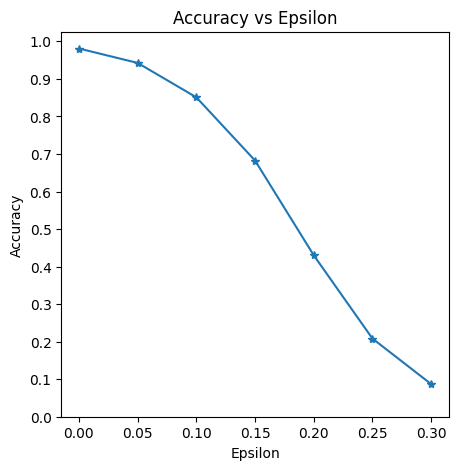

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

다른 샘플 예제 테스트


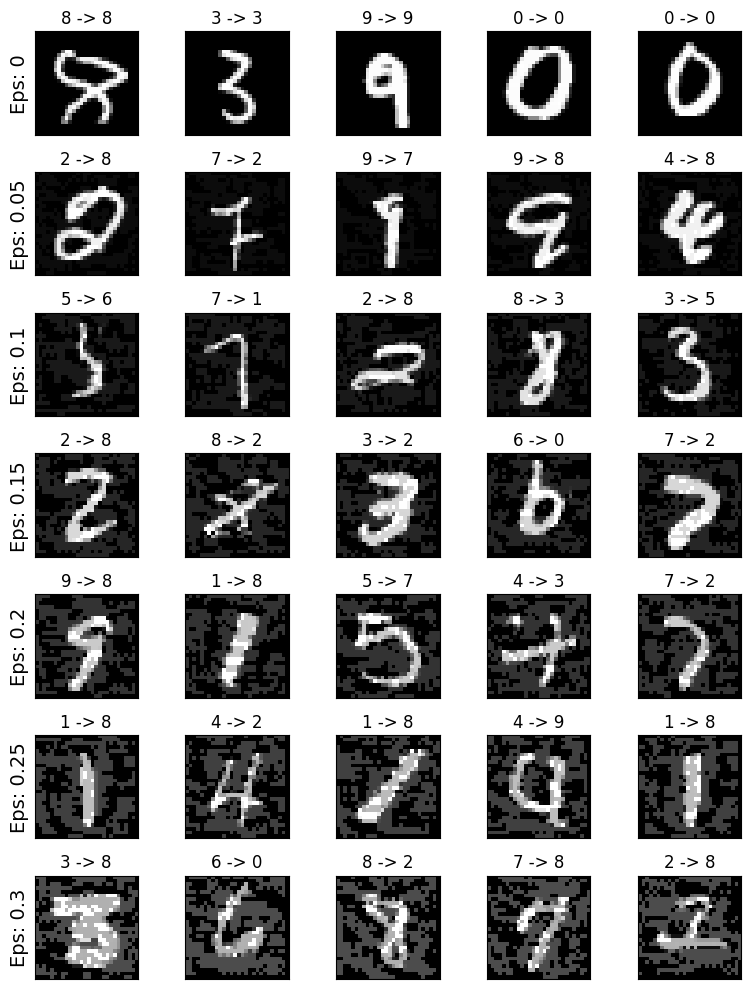

In [8]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()